In [1]:
import pandas as pd
import numpy as np
from xbbg import blp, pipeline
import datetime as dt
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import xlwings as xw
import scipy.optimize as opt
from QuantLib import *
from scipy.optimize import minimize

Rebuilding cache of generated files for COM support...
Checking 00020813-0000-0000-C000-000000000046x0x1x9
Could not add module (IID('{00020813-0000-0000-C000-000000000046}'), 0, 1, 9) - <class 'ImportError'>: cannot import name 'Dispatch' from partially initialized module 'win32com.client' (most likely due to a circular import) (c:\Users\S542282\Desktop\fede_env\Lib\site-packages\win32com\client\__init__.py)
Done.


In [2]:
from scipy.stats import norm

In [3]:
today = dt.date.today()
maturity = ['1W', '2W', '3W','1M', '2M', '3M', '6M', '9M', '12M', '2Y', '3Y', '4Y', '5Y', '7Y', '10Y']
calendar = UnitedStates(UnitedStates.NYSE)

In [4]:
side = 'sell'

In [5]:
spot = blp.bdp('EURUSD BGN Curncy', flds=['Security_Name','mid'])['mid'].values[0]

In [6]:
ticker = ['EUR{} Curncy'.format(i) for i in maturity]
pts = blp.bdp(ticker, flds=['Security_Name','mid', 'maturity'])
pts = pts.sort_values(by='mid')
pts['mid'] = spot + pts['mid'].values/10000 

h = [ (i - today).days for i in pts['maturity'].values]

fwd_fx_mid = interpolate.CubicSpline(h, pts['mid'])

maturity[8] = '1Y'

atm


In [7]:
ticker_atmvol =['EURUSDVON Curncy'] + ['EURUSDV{} Curncy'.format(i) for i in maturity]
atmvol = [blp.bdp(i, flds=['Security_Name', 'mid','maturity']) for i in ticker_atmvol]
atmvol = pd.concat(atmvol, axis=0)

risk rev

In [8]:
ticker_rrvol25 =['EURUSD25RON Curncy'] + ['EURUSD25R{} Curncy'.format(i) for i in maturity]
rrvol25 = [blp.bdp(i, flds=['Security_Name', 'mid','maturity']) for i in ticker_rrvol25]
rrvol25 = pd.concat(rrvol25, axis=0)
ticker_rrvol10 =['EURUSD10RON Curncy'] + ['EURUSD10R{} Curncy'.format(i) for i in maturity]
rrvol10 = [blp.bdp(i, flds=['Security_Name', 'mid','maturity']) for i in ticker_rrvol10]
rrvol10 = pd.concat(rrvol10, axis=0)

fly

In [9]:
ticker_bfvol25 =['EURUSD25BON Curncy'] + ['EURUSD25B{} Curncy'.format(i) for i in maturity]
bfvol25 = [blp.bdp(i, flds=['Security_Name', 'mid','maturity']) for i in ticker_bfvol25]
bfvol25 = pd.concat(bfvol25, axis=0)
ticker_bfvol10 =['EURUSD10BON Curncy'] + ['EURUSD10B{} Curncy'.format(i) for i in maturity]
bfvol10 = [blp.bdp(i, flds=['Security_Name', 'mid','maturity']) for i in ticker_bfvol10]
bfvol10 = pd.concat(bfvol10, axis=0)


surface

In [10]:
surf = pd.DataFrame(np.array([atmvol['mid'].values,
                     rrvol10['mid'].values,
                     rrvol25['mid'].values,
                     bfvol10['mid'].values,
                     bfvol25['mid'].values,
                     ]).T, index=['on']+ maturity, columns=['ATM','RR10','RR25','BF10','BF25'])


to call put 

In [11]:
surf['Call25'] = surf['ATM'] + surf['BF25'] + .5 * surf['RR25']
surf['Call10'] = surf['ATM'] + surf['BF10'] + .5 * surf['RR10']
surf['Put25'] = surf['ATM'] + surf['BF25'] - .5 * surf['RR25']
surf['Put10'] = surf['ATM'] + surf['BF10'] - .5 * surf['RR10']
surf['fwd'] = [spot] + list(pts['mid'].values)

from delta to strike 

In [12]:
def strike_from_delta_forward(F, T, sigma , delta, sofr, option_type='call'):

    sigma = sigma * 0.01   

    if option_type == 'call':
        d1 = np.array([norm.ppf(delta * np.exp(sofr(i)/100 * i)) if i < 1 else norm.ppf(delta) for i in T])

    else:
        delta = delta + 1
        d1 = np.array([norm.ppf(delta * np.exp(sofr(i)/100 * i)) if i < 1 else norm.ppf(delta) for i in T])
    
    K = F * np.exp(-d1 * sigma * np.sqrt(T) + 0.5 * sigma**2 * T)
    return K

In [ ]:
F = surf['fwd'].values  
[ (i - today).days for i in pts['maturity'].values]     
T = np.array([1] + h)/360     

In [14]:
sofr_date = ['TSFR{} Index'.format(i) for i in ['1M', '3M', '6M', '9M', '12M']]
sofr = [blp.bdp(i, flds=['Security_Name', 'PX_LAST']) for i in sofr_date]
sofr = pd.concat(sofr, axis=0)
sofr['mat'] = [T[4],T[6],T[7],T[9]]
sofr = interpolate.interp1d(sofr['mat'].values, sofr['px_last'].values, kind='linear', fill_value='extrapolate')

In [15]:
sigmac25 = surf['Call25'].values       
sigmac10 = surf['Call10'].values
sigmap25 = surf['Put25'].values
sigmap10 = surf['Put10'].values

K_call25 = strike_from_delta_forward(F, T, sigmac25, 0.25, sofr, option_type='call')
K_call10 = strike_from_delta_forward(F, T, sigmac10, 0.10, sofr, option_type='call')
K_Put25 = strike_from_delta_forward(F, T, sigmap25,-0.25, sofr, option_type='put')
K_Put10 = strike_from_delta_forward(F, T, sigmap10, -0.10, sofr, option_type='put')

In [16]:
surf_k = pd.DataFrame(np.array([T, K_Put10,K_Put25,  F,K_call25, K_call10]).T, index=['on']+ maturity, columns=['mat','put10','put25','atm','call25','call10'])
surf_k

,mat,put10,put25,atm,call25,call10
on,0.002778,1.134240,1.138024,1.142050,1.146166,1.150109
1W,0.025000,1.124486,1.133273,1.142578,1.152506,1.162509
2W,0.044444,1.119016,1.130734,1.143106,1.156565,1.170358
3W,0.063889,1.114969,1.128909,1.143645,1.159937,1.176897
1M,0.088889,1.110053,1.126719,1.144329,1.163967,1.184589
2M,0.175000,1.098360,1.122002,1.146707,1.174629,1.204837
3M,0.261111,1.090196,1.119178,1.149110,1.183001,1.220532
6M,0.513889,1.070425,1.113370,1.156079,1.204082,1.259522
9M,0.763889,1.054119,1.109397,1.162710,1.221807,1.292877
1Y,1.019444,1.058127,1.113794,1.168875,1.241531,1.326912


In [17]:
vol_df = surf[['Put10','Put25','ATM','Call25','Call10']]

In [18]:
surf[['ATM', 'Call25', 'Call10', 'Put25', 'Put10']]

,ATM,Call25,Call10,Put25,Put10
on,9.8975,10.08125,10.38875,9.96875,10.17625
1W,7.7575,8.04625,8.49375,7.70875,7.88125
2W,7.7650,8.14625,8.66625,7.69375,7.87375
3W,7.7675,8.19750,8.78250,7.64250,7.81250
1M,7.8825,8.34500,8.97125,7.74000,7.90875
2M,7.8600,8.38250,9.11875,7.69750,7.89125
3M,7.7350,8.28250,9.08875,7.57250,7.79125
6M,7.6500,8.26125,9.18125,7.49875,7.80875
9M,7.6125,8.27125,9.30875,7.46875,7.83625
1Y,7.6300,8.33500,9.44875,7.51000,7.94125


sabr interpolation

In [19]:
moneyness = np.linspace(0.75, 1.25, 50) * spot
volmat = np.zeros([len(T), len(moneyness)])
cons=(
{'type': 'ineq', 'fun': lambda x:  0.99 - x[1]},
{'type': 'ineq', 'fun': lambda x: x[1]},    
{'type': 'ineq', 'fun': lambda x: x[3]}
)
bnds = ((1e-6, 5.0), (0.0, 1.0),(1e-6, 5.0), (-0.999, 0.999))

In [20]:
def f(params):
    vols = np.array([
        sabrVolatility(strike, fwd, expiryTime, *params)
        for strike in strikes
    ])*100
    err = ((vols - np.array(marketVols))**2 ).mean() **.5
    return err

In [21]:
for i in range(len(T)):

    params = [0.1] * 4
    strikes = surf_k.iloc[i,1:].values
    fwd = F[i]
    expiryTime = T[i]
    marketVols = vol_df.iloc[i,:].values/100

    result = minimize(f, params, constraints=cons, tol = 0.0001, bounds = bnds)
    new_params = result['x']
    volmat[i,:] = np.array([sabrVolatility(strike, fwd, expiryTime, *new_params)*100 for strike in moneyness])


c:\Users\S542282\Desktop\fede_env\Lib\site-packages\scipy\optimize\_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [22]:
interpolator = interpolate.RegularGridInterpolator((T, moneyness), volmat)

In [23]:
ss = np.linspace(0.9, 1.1, 20) * spot
date = np.linspace(0.01, 1, 20)    
ss , date = np.meshgrid(ss, date)

In [ ]:
estimated_vol  = interpolator((date, ss))

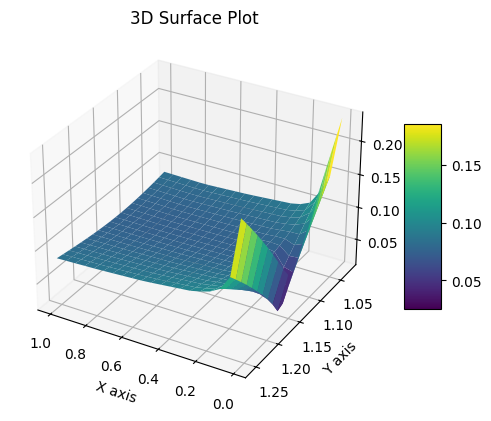

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(date,ss,  estimated_vol, cmap='viridis', edgecolor='none')

# Add labels
ax.set_title('3D Surface Plot')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=30, azim=120)

# Show the plot
plt.show()